# **TD on Detection of tumours in breast scans using Faster-RCNN**

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# Install required APIs and download database

 - Run the following cell to install the required packages and download the dataset.

All the experiments will be constructed on the publicly available dataset MIAS Mammography1
.
The dataset contains 322 left and right mammograms. 

The size of the images is 1024x1024
pixels, while annotations are provided in the form of boundary boxes about seven different class
abnormalities [CALC Calcification CIRC Well-defined/circumscribed masses SPIC Spiculated
masses MISC Other, ill-defined masses ARCH Architectural distortion ASYM Asymmetry
NORM Normal] and two different severity abnormality [B Benign M Malignant]. 

Please
download the dataset and read more about the annotations in the Info.txt file.

In [0]:
%%shell

# cd '/content/drive/My Drive/mva_td/student_test/'

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install
cd ..
cd ..

# Install torchvision useful functions
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

cd ..
# Download the database

mkdir mias-db && cd mias-db
wget http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
tar -zxvf all-mias.tar.gz
rm all-mias.tar.gz && cd ..

# Imports

In [0]:
# MAIN_PATH = '/content/drive/My Drive/mva_td/'


import os
# os.chdir(MAIN_PATH)


import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from engine import train_one_epoch, evaluate
import utils

from tqdm import tqdm


# Dataset

### a. Read the dataset and split into train, validation and test sets.

In the MIAS database, a bounding box is indicated by the coordinates of its center (x, y) and a radius r.
All bounding boxes are square.



In [0]:
# Path to database
mias_db_path = '/content/drive/My Drive/mva_td/mias-db/'
mias_db_path = './mias-db/'
info_file = 'Info.txt'
# Some cases contain abnormalities so we will exclude them.
to_exclude = ('mdb216', 'mdb233', 'mdb245', 'mdb059')

# Images to include in the validation set
val_set = ('mdb001', 'mdb002', 'mdb005', 'mdb010', 'mdb012', 'mdb013')
# Images to include in the test set
test_set = ('mdb090', 'mdb091', 'mdb121', 'mdb134', 'mdb145', 'mdb218')

# Read the info (class and bounding box) for each image
with open(os.path.join(mias_db_path, info_file), 'r') as fp:
    info = [f.strip() for f in fp.readlines() if f.startswith('mdb') and not f.startswith(to_exclude) 
    and not f.startswith(test_set)
    and not f.startswith(val_set)]
with open(os.path.join(mias_db_path, info_file), 'r') as fp:    
    test_info = [f.strip() for f in fp.readlines() if f.startswith(test_set)]
with open(os.path.join(mias_db_path, info_file), 'r') as fp:
    val_info = [f.strip() for f in fp.readlines() if f.startswith(val_set)]

In [0]:
# Make lists of the images' paths for the train, validation and test sets
# and analog lists to store the images' classes.
img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in info]
val_img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in val_info]
test_img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in test_info]

cls_names = ["NOTUMOUR" if 'NORM' in f.split(' ')[2] else "TUMOUR" for f in info]
val_cls_names = ["NOTUMOUR" if 'NORM' in f.split(' ')[2] else "TUMOUR" for f in val_info]
test_cls_names = ["NOTUMOUR" if 'NORM' in f.split(' ')[2] else "TUMOUR" for f in test_info]

# Make lists in which to store the bounding boxes in x1, y1, x2, y2 format.
bboxes = []
for f in info:
    if 'NORM' in f: bboxes.append([])
    else:
        x, y, r = int(f.split(' ')[4]), 1024-int(f.split(' ')[5]), int(f.split(' ')[6])
        """FILL HERE"""
        bboxes.append([x-r, y-r, x+r, y+r]) 

val_bboxes = []
for f in val_info:
    x, y, r = int(f.split(' ')[4]), 1024-int(f.split(' ')[5]), int(f.split(' ')[6])  
    """FILL HERE"""          
    val_bboxes.append([x-r, y-r, x+r, y+r])  
                   
test_bboxes = []
for f in test_info:
    x, y, r = int(f.split(' ')[4]), 1024-int(f.split(' ')[5]), int(f.split(' ')[6])  
    """FILL HERE"""          
    test_bboxes.append([x-r, y-r, x+r, y+r])

### b. Create your custom dataset class.

This class shoud implement:

- `__getitem__(self, image_id)`: this function should return a PIL image and a `target` dictionary containing relevant information about that image. 
- `self.img_dict`: a dictionary that maps the id of an image to relevant info about it (path of the image, bounding box coordinates, class). __Warning__: what happens when there is no tumour ? Create fake bounding boxes.
- `self.class_names`: a dictionary that maps the tumour names to labels read by the model. "TUMOUR" --> 1, "NOTUMOUR" --> 2
- `__len__(self)`: this function should return the length of the dataset.
- `load_image(self, image_id`: this function should return the RGB image indicated by the `ìmage_id`
- `__init__(self, img_list, cls_names, bboxes, transforms, name)` : the class constructor in which you should implement `self.img_dict`.

One important detail is that the constructor of the dataset should have the variable `transforms`, which is set inside the constructor. It should then be used in `__getitem__(self, image_id)` as shown below.

In [0]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, cls_names, bboxes, transforms=None, name="train"):
        self.transforms = transforms
        self.name = name
        self.img_list = img_list
        self.cls_names = cls_names
        self.bboxes = bboxes
        """FILL HERE"""
        self.class_names = {
            "TUMOUR": 1,
            "NOTUMOUR": 2,
        }   

        self.id_class_dict = {self.class_names[name]: name for name in self.class_names}

        # Add a random bounding box for all images that are NORMAL. 
        for i in range(len(self.cls_names)):
            if cls_names[i] != "NOTUMOUR":
                continue    
            # Draw a random centre from a normal distribution with mean 50 and std 20. 
            radius = 100 #int(np.floor(np.random.randn()*20 + 50))
            # Generate a random bounding box for the "NORM" images, but only on the part of the
            # image where something is present. 
            """ FILL THIS """
            copy_ = imageio.imread(img_list[i])
            copy_[:radius, :] = 0
            copy_[-radius:, :] = 0
            copy_[:, :radius] = 0
            copy_[:, -radius:] = 0
            mask = copy_ > 0
            mask_id = np.where(mask)
            centre = np.random.randint(mask_id[0].size)
            centre = mask_id[1][centre], mask_id[0][centre]        
            self.bboxes[i] = [centre[0]-radius, centre[1]-radius, centre[0]+radius, centre[1]+radius]

        """FILL HERE"""
        self.img_dict = {idx:{"path":img_path,
                              "class":self.class_names[cls_names[idx]],
                              "bbox": bboxes[idx]} 
                        for idx, img_path in enumerate(img_list)}

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        image = imageio.imread(self.img_dict[image_id]['path']).astype(np.uint8)[...,None]
        # Stack image on itself 3 times to simulate RGB image (3 channels required for model's input)
        image = np.concatenate((image, image, image), axis=2)     
        return image


    def __getitem__(self, image_id):   
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly.
        """
        # Retrieve the image and appropriate info
        """FILL HERE
        Create the image, label and bbox variables using the implemented img_dict dictionary.
        """
        image = Image.fromarray(self.load_image(image_id)).convert("RGB")
        label = self.img_dict[image_id]["class"]
        bbox = self.img_dict[image_id]["bbox"]

        # Convert everything to tensor
        image_id = torch.tensor([image_id])
        boxes = torch.as_tensor([bbox], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)

        # Compute the area of the bounding box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Use the COCO template for targets to be able to evaluate the model with COCO API
        target = {"boxes": boxes,
                  "labels": labels,
                  "image_id": image_id,
                  "area": area,
                  "iscrowd": torch.as_tensor([0], dtype=torch.int64)}

        # Important line! don't forget to add this
        if self.transforms:
            image, target = self.transforms(image, target)
        # return the image, the boxlist and the idx in your dataset
        return image, target

    def __len__(self):
        return len(self.img_list)

### c. Data augmentation

The `get_transform(train)` function applies random flips to the images during training.

In order to flip an image as well as the corresponding bounding box coordinates, a `RandomHorizontalFlip(object)` class was implemented.

If you wish, you can implement your own data augmentation class to perform vertical flips or rotations.



    class RandomHorizontalFlip(object):

        def __init__(self, prob):
            self.prob = prob

        def __call__(self, image, target):
            if random.random() < self.prob:
                height, width = image.shape[-2:]
                image = image.flip(-1)
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox

                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
            return image, target

In [0]:
import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### d. Instantiate train, validation and test sets

- Create your train, validation and test sets using the `CancerDataset` class.
- How imbalanced is your dataset ?

In [0]:
""" FILL HERE 
create your train val and test datasets
"""
train = CancerDataset(img_list, cls_names, bboxes, get_transform(train=True), name="train")
val = CancerDataset(val_img_list, val_cls_names, val_bboxes, get_transform(train=False), name="validation")
test = CancerDataset(test_img_list, test_cls_names, test_bboxes, get_transform(train=False), name="test")

print("Number of images in training set: {}".format(len(train)))
print("Number of images in validation set: {}".format(len(val)))
print("Number of images in test set: {}".format(len(test)))

Number of images in training set: 313
Number of images in validation set: 7
Number of images in test set: 6


### e. Visualize some images with their bounding boxes

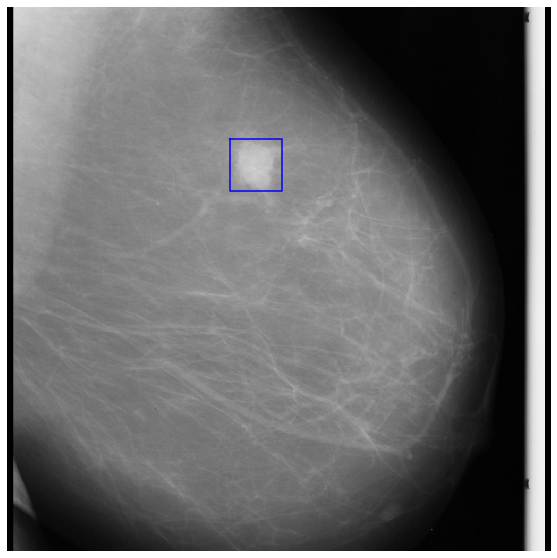

In [0]:
"""FILL HERE"""
# Get image and image info from test set
img_id = 3
img, info = test[img_id]
# Get bounding box coordinates
x1,y1,x2,y2 = info['boxes'][0]

plt.figure(figsize=(10,10))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap="gray")
plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')
plt.axis('off')
plt.show()


### f. Use data loaders


In this section, we instantiate data loaders that will be used to generate batches of images on the fly during training.

In [0]:
# Data loaders
torch.manual_seed(1)

data_loader = torch.utils.data.DataLoader(
    train, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    val, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    test, batch_size=4, shuffle=False, num_workers=8,
    collate_fn=utils.collate_fn)

# Set up the model





### a. Model's configuration
https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

Familiarize yourself with the various arguments of the FasterRCNN class.


1. Compute the images' means and std so that the model can perform input normalization with the image_mean and image_std arguments. The outputs of the functions should be tuples.

2. Compute the number of parameters in your model.

In [0]:
def compute_means(dataset):
    return tuple(np.mean([np.mean(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

In [0]:
def compute_stds(dataset):
    return tuple(np.std([np.std(dataset[idx][0].numpy(), axis=(1,2)) for idx in tqdm(dataset.img_dict)], axis=0))

In [0]:
image_mean = compute_means(train)
image_std = compute_stds(train)


print("Means: {}".format(image_mean))
print("Stds: {}".format(image_std))

100%|██████████| 313/313 [00:22<00:00, 10.43it/s]

Means: (0.21301277, 0.21301277, 0.21301277)
Stds: (0.03264069, 0.03264069, 0.03264069)


In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             image_mean=image_mean,
                                                             image_std=image_std)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 3  # 2 classes (tumomur or no tumour) + background

# get number of input channels for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### b. Compute the number of trainable parameters in the model

In [0]:
""" FILL HERE """
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {}".format(params))

Number of trainable parameters: 41081886


# Training



### a. Optimizer and Hyperparameters




- Define the optimizer and the associated hyperparameters to use for training.

- Use a learning rate scheduler to slowly decrease the learning rate during the training.

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 3 classes only - background, tumour and no tumour
num_classes = 3
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

""" FILL HERE"""
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate
# Change the scheduler type if you wish
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.5)

### b. Training and validation functions for on epoch.



- Implement your own training function for one epoch. Your function should output a dictionary containing the overall loss values computed during the epoch.
- Implement a similar function meant to compute the losses over the validation set (NB: no backprop)

In [0]:
import math
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for i, values in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Feed the training samples to the model and compute the losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        # Pytorch function to initialize optimizer
        optimizer.zero_grad()
        # Compute gradients or the backpropagation
        losses.backward()
        # Update current gradient
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # Record losses to plot learning curves
        if i == 0: 
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history

In [0]:
def validate_one_epoch(model, data_loader, device=device, print_freq=100):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Validation: "
    for i, values in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images, targets = values
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

        # Record losses to plot learning curves
        if i == 0: 
            history = {key: val.cpu().detach() for key, val in loss_dict_reduced.items()}
            history['loss'] = losses_reduced.cpu().detach()
        else:
            for key, val in loss_dict_reduced.items():history[key] += val.cpu().detach()
            history['loss'] += losses_reduced.cpu().detach()
    return history

### c. Train your model

BONUS: use tensorboard to watch learning curves and predictions of bounding boxes evolve as you train your model.

In [0]:
num_epochs = 3

for epoch in range(num_epochs):

    # Train for one epoch, printing every 10 iterations
    train_his_ = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)

    # Compute losses over the validation set
    val_his_ = validate_one_epoch(model, val_data_loader, device, print_freq=100)

    # Update the learning rate
    lr_scheduler.step()

    # Store loss values to plot learning curves afterwork.
    if epoch == 0: 
        train_history = {k: [v] for k, v in train_his_.items()}
        val_history = {k: [v] for k, v in val_his_.items()}
    else: 
        for k, v in train_his_.items():train_history[k] += [v]
        for k, v in val_his_.items():val_history[k] += [v]

    # Save the model if you wish. You can add a criteria before saving, for example
    # if the validation decreases.
    # save_path = "/content/drive/My Drive/mva_td/saved_models/my_model"
    # torch.save(model, save_path)

    torch.cuda.empty_cache()

Epoch: [0]  [ 0/79]  eta: 0:05:40  lr: 0.001000  loss: 3.9173 (3.9173)  loss_classifier: 2.9253 (2.9253)  loss_box_reg: 0.0065 (0.0065)  loss_objectness: 0.9713 (0.9713)  loss_rpn_box_reg: 0.0143 (0.0143)  time: 4.3082  data: 2.4594  max mem: 3044
Epoch: [0]  [78/79]  eta: 0:00:00  lr: 0.001000  loss: 0.1603 (0.2981)  loss_classifier: 0.0647 (0.1408)  loss_box_reg: 0.0186 (0.0228)  loss_objectness: 0.0741 (0.1168)  loss_rpn_box_reg: 0.0057 (0.0177)  time: 0.7255  data: 0.0086  max mem: 3316
Epoch: [0] Total time: 0:01:03 (0.7990 s / it)
Validation:   [0/2]  eta: 0:00:01  loss: 0.1222 (0.1222)  loss_classifier: 0.0628 (0.0628)  loss_box_reg: 0.0052 (0.0052)  loss_objectness: 0.0450 (0.0450)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 0.9503  data: 0.5943  max mem: 3316
Validation:   [1/2]  eta: 0:00:00  loss: 0.1222 (0.1337)  loss_classifier: 0.0588 (0.0608)  loss_box_reg: 0.0052 (0.0057)  loss_objectness: 0.0450 (0.0566)  loss_rpn_box_reg: 0.0092 (0.0106)  time: 0.6132  data: 0.3002  max

### d. Learning curves

Plot the learning curves using the train_history and val_history

Is your model overfitting ?



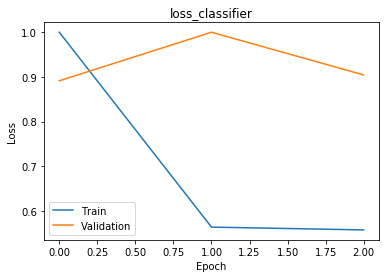

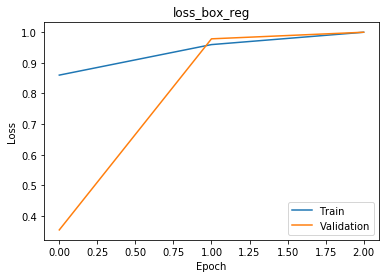

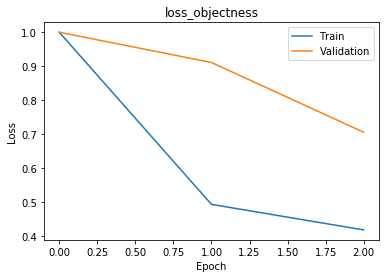

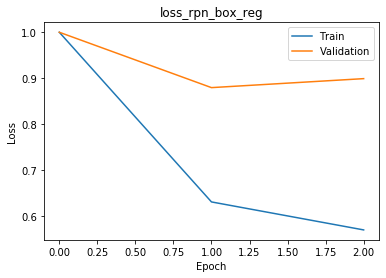

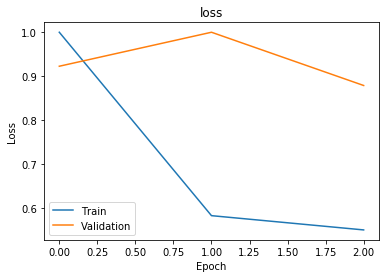

In [0]:
for k in train_history:
    """ FILL HERE """
    plt.plot(np.arange(len(train_history[k]), dtype=int), train_history[k]/np.max(train_history[k]), label='Train')
    plt.plot(np.arange(len(val_history[k]), dtype=int), val_history[k]/np.max(val_history[k]), label='Validation')
    plt.title(k)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Inference time over the test set



In [0]:
# Reload your best model here if you have saved one
# model = torch.load(save_path)

### a. Keeping only the most relevant boxes : Non Maximum Suppression

1. Implement non max suppression to keep only non overlapping predicted bounding boxes.
2. Visualize effect of NMS on predictions

In [0]:
def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    """ FILL HERE """
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

In [0]:
def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    """ FILL HERE """
    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


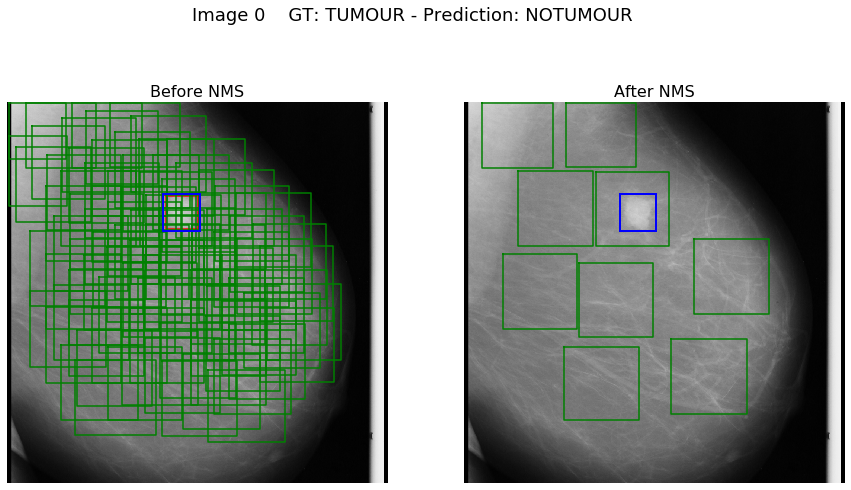

In [0]:
# VISUALIZATION

# CHOOSE A THRESHOLD FOR NMS
threshold = 0.001 


# Select image in test set
img, target = test[3]
# Put model in evaluation mode
model.eval()
# Perform prediction
with torch.no_grad(): prediction = model([img.to(device)])

# Retrieve ground-truth and predicted label
gt_label = test.id_class_dict[target['labels'].item()]
pred_label = test.id_class_dict[prediction[0]["labels"][0].item()]

# Retrieve predicted bounding boxes and scores 
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Plot predicted bouding boxes before and after NMS
plt.figure(figsize=(15, 10))
plt.suptitle("Image {}    GT: {} - Prediction: {}".format(0, gt_label, pred_label), y=0.9, fontsize=18)
plt.subplot(121)
plt.title("Before NMS", fontsize=16)
plt.axis('off')
for i in range(len(boxes)):        

    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][0]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

    box_label = test.id_class_dict[prediction[0]["labels"][i].item()]
    if "NO" in box_label: c = "g-"
    else: c = "r-"
    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)


kept_boxes = non_max_suppression(boxes, scores, threshold)
plt.subplot(122)
plt.title('After NMS', fontsize=16)
plt.axis('off')
for i in kept_boxes:        
    
    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    x1,y1,x2,y2 = target["boxes"][0]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

    box_label = test.id_class_dict[prediction[0]["labels"][i].item()]
    if "NO" in box_label: c = "g-"
    else: c = "r-"
    x1,y1,x2,y2 = prediction[0]['boxes'][i]
    plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)
plt.show()

### b. Visualize predictions over the test set

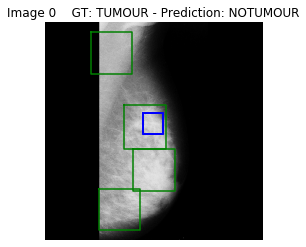

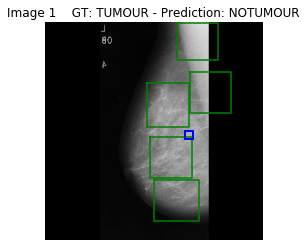

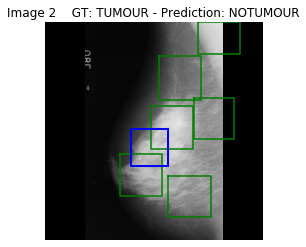

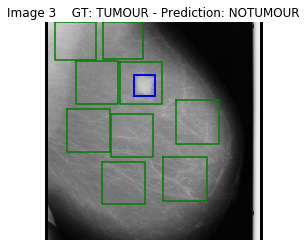

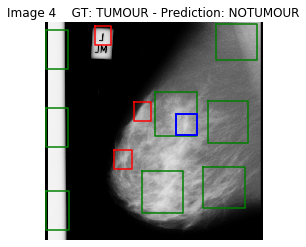

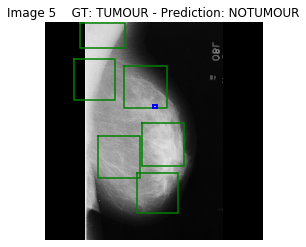

In [0]:
# CHOOSE A THRESHOLD FOR NMS
threshold = 0.01


for idx in test.img_dict:
    # pick one image from the test set
    img, target = test[idx]
    # put the model in evaluation mode
    model.eval()
    # Perform prediction
    with torch.no_grad(): prediction = model([img.to(device)])

    gt_label = test.id_class_dict[target['labels'].item()]
    pred_label = test.id_class_dict[prediction[0]["labels"][0].item()]

    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    kept_boxes = non_max_suppression(boxes, scores, 0.01)
    for i in kept_boxes:       
        plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
        x1,y1,x2,y2 = target["boxes"][0]
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'b-')

        box_label = test.id_class_dict[prediction[0]["labels"][i].item()]
        if "NO" in box_label: c = "g-"
        else: c = "r-"
        x1,y1,x2,y2 = prediction[0]['boxes'][i]
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], c)

    plt.title("Image {}    GT: {} - Prediction: {}".format(idx, gt_label, pred_label))
    plt.axis('off')
    plt.show()

### c. Evaluation metrics

1. Implement accuracy.
2. Implement the F1-score metric to evaluate the model's classification accuracy between tumour and tumourless images.
3. Implement your own IoU to evaluate bounding box regression.
4. Compare metrics when the model is evaluated on the train set and the test set


In [0]:
def accuracy(gt_labels, pred_labels):
    return len(np.where(gt_labels == pred_labels)[0])/len(gt_labels)

In [0]:
def f1_score(gt_labels, pred_labels):
    tp = len(gt_labels == pred_labels)
    fp = len(np.where(pred_labels[np.where(gt_labels == 2)] == 1)[0])
    fn = len(np.where(pred_labels[np.where(gt_labels == 1)] == 2)[0])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print('Precision: {:.3f}'.format(precision))
    print('Recall: {:.3f}'.format(recall))
    return 2 * precision * recall / (precision + recall)

In [0]:
def IoU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA1, yA1, xA2, yA2 = boxA 
    xB1, yB1, xB2, yB2 = boxB
    x1 = max(xA1, xB1)
    y1 = max(yA1, yB1)
    x2 = min(xA2, xB2)
    y2 = min(yA2, yB2)
    # compute the area of intersection rectangle
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (xA2 - xA1 + 1) * (yA2 - yA1 + 1)
    boxBArea = (xB2 - xB1 + 1) * (yB2 - yB1 + 1)
    union = boxAArea + boxBArea - intersection
    return intersection / union

In [0]:
def evaluate(model, dataset, device):
    model.eval()
    gt_labels, pred_labels = np.array([]), np.array([])
    gt_boxes, pred_boxes = np.empty(4), np.empty(4)
    for idx in tqdm(dataset.img_dict):
        img, target = dataset[idx]
        with torch.no_grad(): prediction = model([img.to(device)])

        gt_labels = np.concatenate([gt_labels, np.array([target['labels'].item()])], axis=-1)
        pred_labels = np.concatenate([pred_labels, np.array([prediction[0]["labels"][0].item()])], axis=-1)

        gt_boxes = np.vstack((gt_boxes, target['boxes'][0]))
        pred_boxes = np.vstack((pred_boxes, prediction[0]['boxes'][0].cpu()))

    f1 = f1_score(gt_labels, pred_labels)
    print("F1_score over {} set: {:.2f}".format(dataset.name, f1))
    average_iou = np.mean([IoU(gt_boxes[i], pred_boxes[i]) for i in range(len(gt_boxes))])
    print("Average IoU over {} set: {:.2f}".format(dataset.name, average_iou))
    acc = accuracy(gt_labels, pred_labels)
    print('Accuracy over {} set: {:.3f}'.format(dataset.name, acc))

In [0]:
evaluate(model, train, device)
evaluate(model, test, device)

  0%|          | 1/313 [00:00<00:33,  9.20it/s]

ok


 17%|█▋        | 1/6 [00:00<00:00,  9.85it/s]

Precision: 0.918
Recall: 0.779
F1_score over train set: 0.84
Average IoU over train set: 0.07
Accuracy over train set: 0.626
ok


100%|██████████| 6/6 [00:00<00:00,  9.72it/s]

Precision: 1.000
Recall: 0.500
F1_score over test set: 0.67
Average IoU over test set: 0.26
Accuracy over test set: 0.000


### d. Evaluation

Use the COCO evaluation function to compute metrics such as mAP over the test set

In [0]:
from engine import evaluate
evaluate(model, test_data_loader, device)

creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.3274 (0.3274)  evaluator_time: 0.0037 (0.0037)  time: 0.8081  data: 0.4633  max mem: 4347
Test:  [1/2]  eta: 0:00:00  model_time: 0.1646 (0.2460)  evaluator_time: 0.0018 (0.0027)  time: 0.4930  data: 0.2341  max mem: 4347
Test: Total time: 0:00:01 (0.5767 s / it)
Averaged stats: model_time: 0.1646 (0.2460)  evaluator_time: 0.0018 (0.0027)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50